In [3]:
!pip install transformers
!pip install datasets
!pip install -U PyYAML

     |████████████████████████████████| 2.1MB 9.2MB/s 
     |████████████████████████████████| 901kB 40.3MB/s 
     |████████████████████████████████| 3.3MB 50.0MB/s 
     |████████████████████████████████| 204kB 8.5MB/s 
     |████████████████████████████████| 245kB 15.1MB/s 
     |████████████████████████████████| 112kB 18.7MB/s 
     |████████████████████████████████| 645kB 7.8MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


1. Separate your text into two strings:

    i. all the books concatenated that belong to the "successful" class

    ii. all the book concatenated that belong to the "unsuccessful" class

2. Get the vocabulary for these two strings: $V$

3. Count the number of words 
    - in the whole text: $n$
    - in the successful class: $n_s$
    - in the unsuccessful class: $n_u$

4. For each word in your vocabulary
    - Count the number of occurrences in the successful class: $C(word, successful)$
    - Count the number of occurrences in the unsuccessful class: $C(word, unsuccessful)$

5. For each word in your vocabulary
    - Calculate its probability of being in the successful class: $p(word, successful) = \frac{C(word, successful) + \alpha}{n_s + \alpha * |V|}$
    - Calculate its probability of being in the unsuccessful class: $p(word, unsuccessful) = \frac{C(word, unsuccessful) + \alpha}{n_s + \alpha * |V|}$
    - Calculate its probability of being in the corpus: $p(word, \cdot) = \frac{C(word, successful)+C(word, unsuccessful)+2 \alpha}{n + 2 \alpha * |V|}$

6. Calculate the PMI for each word, class pair

$$PMI(word, class) = log(\frac{p(word,class)}{p(word,\cdot)p(\cdot,class)})$$
where $p(\cdot, class) = \frac{n_{class}}{n}$

In [32]:
from pathlib import Path
import pandas as pd
import yaml
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
auth.authenticate_user()

Mounted at /content/drive


# Shared Functions

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

def get_successful_and_unsuccessful_text(data_yaml):
  counter = 0
  text_successful = ""
  text_unsuccessful = ""
  with open(data_yaml) as file:
      documents = yaml.full_load(file)
      for train_test, doc in documents.items():
          for d in doc:
              path = list(dataset_base.rglob(d))[0]
              classBool = os.path.dirname(path).rsplit('/', 1)[1] == "success"
              with open(path, 'r', encoding = 'utf-8') as file:
                book = file.read()
                book = book.replace('\n', ' ')
                if classBool == True:
                  text_successful = text_successful + " " + book
                else:
                  text_unsuccessful = text_unsuccessful + " " + book

                counter = counter + 1
                if counter % 100 == 0:
                  print(counter)

  return text_successful, text_unsuccessful


def get_successful_and_unsuccessful_text_csv(data_yaml):
  counter = 0
  text_successful = ""
  text_unsuccessful = ""
  with open(data_yaml) as file:
      documents = yaml.full_load(file)
      for train_test, doc in documents.items():
          for d in doc:
              
              path = list(dataset_base.rglob(d))[0]
              
              classBool = os.path.dirname(path).rsplit('/', 1)[1] == "success"
              book_df = pd.read_csv(path, names = ['sentence'], skip_blank_lines=True)

              if book_df['sentence'].iloc[0] == '0':
                book_df = book_df.drop(0)

              for _, sent in book_df.iterrows():
                book_sent = str(sent['sentence'])
                if classBool == True:
                  text_successful = text_successful + " " + book_sent
                else:
                  text_unsuccessful = text_unsuccessful + " " + book_sent

              counter = counter + 1
              if counter % 100 == 0:
                print(counter)

  return text_successful, text_unsuccessful

def get_PMIs(text_successful, text_unsuccessful, goodreads_vectorizer):

  len_vocab = len(goodreads_vectorizer.vocabulary_)
  vector_successful = np.array(goodreads_vectorizer.transform([text_successful]).toarray()[0])
  vector_unsuccessful = np.array(goodreads_vectorizer.transform([text_unsuccessful]).toarray()[0])
  id_to_word = {v: k for k, v in goodreads_vectorizer.vocabulary_.items()}

  n_s = np.sum(vector_successful)
  n_u = np.sum(vector_unsuccessful)
  n = n_s + n_u

  alpha = 1
  word_probs_successful = (vector_successful + alpha)/(n_s + alpha*len_vocab)
  word_probs_unsuccessful = (vector_unsuccessful + alpha)/(n_s + alpha*len_vocab)
  word_probs_corpus = (vector_successful + vector_unsuccessful + 2*alpha)/(n + 2*alpha*len_vocab)

  PMI_successful = np.log(word_probs_successful / (word_probs_corpus * (n_s / n)))
  PMI_unsuccessful = np.log(word_probs_unsuccessful / (word_probs_corpus * (n_u / n)))

  return PMI_successful, PMI_unsuccessful

# Pointwise Mutual Info Analysis on Raw Text

In [6]:
dataset_base = Path(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/goodreads_maharjan_trimmed")
data_yaml = dataset_base / "train_test_val_split_goodreads.yaml"

text_successful, text_unsuccessful = get_successful_and_unsuccessful_text(data_yaml)

100
200
300
400
500
600
700
800
900


## Calculate PMIs

In [10]:
goodreads_vectorizer = CountVectorizer()
goodreads_vectorizer.fit([text_successful + text_unsuccessful])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [11]:
PMI_successful, PMI_unsuccessful = get_PMIs(text_successful, text_unsuccessful, goodreads_vectorizer)

## Analysis

In [13]:
id_to_word = {v: k for k, v in goodreads_vectorizer.vocabulary_.items()}

In [20]:
indices_s = (-PMI_successful).argsort()[:10]
[id_to_word[x] for x in indices_s]

['vanslyperken',
 'daoud',
 'retief',
 'evelina',
 'bernick',
 'jimmie',
 'mosby',
 'smallbones',
 'stockmann',
 'nattie']

In [21]:
indices_u = (-PMI_unsuccessful).argsort()[:10]
[id_to_word[x] for x in indices_u]

['doul',
 'forrester',
 'darrell',
 'olof',
 'pepita',
 'milner',
 'dorriforth',
 'hillcrist',
 'mitchener',
 'rynason']

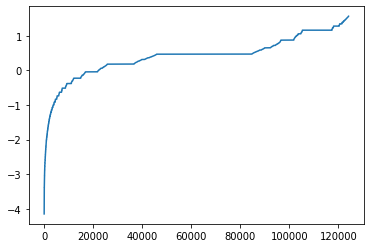

In [28]:
PMI_unsuccessful.sort()
plt.plot(PMI_unsuccessful)

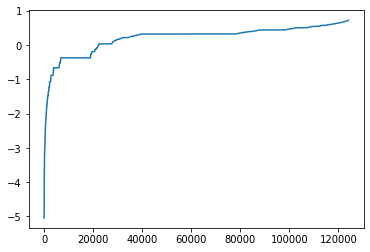

In [31]:
PMI_successful.sort()
plt.plot(PMI_successful)

# Pointwise Mutual Analysis on Text after NER Preprocessing

## Getting the text

### Generating the concatenated text

In [ ]:
dataset_base = Path(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/goodreads_maharjan_trimmed_and_nered")
data_yaml = dataset_base / "train_test_val_split_goodreads.yaml"

text_successful_ner, text_unsuccessful_ner = get_successful_and_unsuccessful_text_csv(data_yaml)

### Getting the already concatenated text

In [7]:
with open('/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/goodreads_maharjan_trimmed_and_nered/all_successful_text.txt', 'r') as file:
    successful_text_ner = file.read()

with open('/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/goodreads_maharjan_trimmed_and_nered/all_unsuccessful_text.txt', 'r') as file:
    unsuccessful_text_ner = file.read()

### Calculate PMIs

In [33]:
goodreads_vectorizer_ner = CountVectorizer()
goodreads_vectorizer_ner.fit([successful_text_ner + unsuccessful_text_ner])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [34]:
PMI_successful_ner, PMI_unsuccessful_ner = get_PMIs(successful_text_ner, unsuccessful_text_ner, goodreads_vectorizer_ner)

### Analysis

In [35]:
id_to_word_ner = {v: k for k, v in goodreads_vectorizer_ner.vocabulary_.items()}

In [36]:
indices_s_ner = (-PMI_successful_ner).argsort()[:10]
[id_to_word[x] for x in indices_s_ner]

['freezer',
 'demonologists',
 'tamped',
 'swollen',
 'loamed',
 'welch',
 'patara',
 'siue',
 'bagnacavallo',
 'japanese']

In [37]:
indices_u_ner = (-PMI_unsuccessful_ner).argsort()[:10]
[id_to_word[x] for x in indices_u_ner]

['disproportional',
 'hauty',
 'wastebasket',
 'endyte',
 'reverse',
 'christen',
 'sport',
 'unsound',
 'memnonian',
 'lenchester']

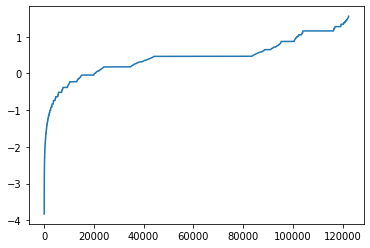

In [38]:
PMI_unsuccessful_ner.sort()
plt.plot(PMI_unsuccessful_ner)

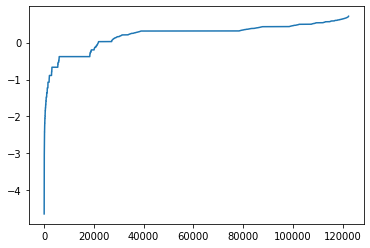

In [39]:
PMI_successful_ner.sort()
plt.plot(PMI_successful_ner)